# Whiteboarder

Whiteboarder is an interactive tool for processing whiteboard images: image clean-up, background removal, etc.

In particular, the whiteboard images to be processed will only have 3 colored pens: black, red, and green on a white background.

## Motivation

Main goal is obviously to have a task specific image processing studio for whiteboard capture pictures. A sub-goal is to explore how far Colab's little UI extensions can be pushed to make an end-user tool out of a notebook, with the code hidden but available for those brave souls who don't mind staring into the angry fruit salad.

## Dev POR and status

While surveying the prior art, found that there are lots of statistical image processing techniques for, say, white balancing but not whiteboards specifically. There are even learning-based solutions that get trained on a large dataset. But for specific whiteboard capture and clean-up, not much was found except Fred on ImageMagick.


So, let's test drive some of the prior art and then get into some hand crafting of modern ML tools. Then it's time for pure Python image manipulation. Python has a lot of very nice and easy to use libraries.


 Tensoflow models on TFX Pipelines, etc. See if Google image search can get a ton of images to train on. Then use non-learning image segmentation techniques to generate training masks for a CNN which will be trained to remove whiteboard background white-ish field.

More potential ML e.g.s: 
- Whiteboard frame detector and image aligner
- Smarter clean-up:VAE, autoencoders
- OCR
- Flowchart recognizer would be next level


## History

2020-04-22:
- Start with OpenCV experiments

2020-04-21:
- Started notebook
- Got some Fred on ImageMagick working but not great at all
  - Halogen yellow is background and fucks with red ink


# Colab config

Colab comes with many preloaded software packages. This section performs any required initialization of the system:
- VM installations 
- Python imports
- File system set up
- Google Drive mount

## Installations

In [1]:
!apt -qq install -y imagemagick # mouthy install!
!apt -q install bc # Fred's whiteboard wants this

!apt -q install tree

imagemagick is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.8).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
bc is already the newest version (1.07.1-2).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
tree is already the newest version (1.7.0-5).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


## Imports

This is the place to start for re-runs after `Runtime` => `Restart Runtime`. Rather than `Run all` choose `Run after` to bypass slow installs above here.

In [2]:
import PIL
import PIL.Image
from IPython.display import display

import cv2
import google.colab
from matplotlib import pyplot as plt
import numpy as np

import seaborn as sns
sns.set() # style="whitegrid")


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## File system workspace

A simple organized workspace on the file system makes for cleaner, more efficient code: e.g. enable a download caching mechanis, useful during frequent restarts as can happen (by design) on Colab.

This notebook will only (intentionally) create files in directory, `/content/whiteboarder/`.

- `/`: file system root
  - `content/`: default home/pwd on Colab 
    - `whiteboarder/`: this notebooks workspace
      - `cache/`: an organized downloads
      - `built/`: output of the notebook
        - various images

In [3]:
workspace_root_path = '/content/whiteboarder/' # /content is Colab's default dir

# TODO: Python all the rest?
!rm -r sample_data/ # Don't need it. Noise.
!mkdir {workspace_root_path} # Put everything in here


rm: cannot remove 'sample_data/': No such file or directory
mkdir: cannot create directory ‘/content/whiteboarder/’: File exists


## Google Drive

It is very easy to mount one's Google Drive to a Colab VM's file system. (Due to the 12 hour limit of Colab VM's, daily sign-in re-mounting is a brief rigmarole.)

Additional there are tons of way to integrate client devices with Google Drive. 

Python downloading from gDrive make for notebooks that re-run well. Repeatedly manually uploading files is a drag; that's much more of a hassle than having to re-login once a day or so.

So, for the above two reasons gDrive makes for a fine repository and relay point for images.

**Note:** this rigmarole only needs to be done once per VM **OR** upon factory reset. So, Runtime reset is much quicker, as long as file system isn't corrupted.

In [4]:
# Mount googld drive

gdrive_dir_name = workspace_root_path + 'gdrive'
google.colab.drive.mount(gdrive_dir_name)

Drive already mounted at /content/whiteboarder/gdrive; to attempt to forcibly remount, call drive.mount("/content/whiteboarder/gdrive", force_remount=True).


In [5]:
ls -lh {gdrive_dir_name}

total 4.0K
drwx------ 5 root root 4.0K Apr 27 20:09 'My Drive'/


In [0]:
gdrive_data_root_path = gdrive_dir_name + '/My Drive/Professional/Reconstrue/Whiteboard/2020/2020-04/'

Annoyingly there's a space in the dir name `/My Drive/` so quoting is in order.

In [7]:
!tree -L 5 "{gdrive_data_root_path}"

/content/whiteboarder/gdrive/My Drive/Professional/Reconstrue/Whiteboard/2020/2020-04/
├── plotting_knee_error_2.jpg
├── plotting_knee_error_3.jpg
├── plotting_knee_error.jpg
├── plotting_knee_error_low_temped.png
└── whiteboard

0 directories, 5 files


Note that file `whiteboard` which is a bash shell downloaded from [Fred](http://www.fmwconcepts.com/imagemagick/downloadcounter.php?scriptname=whiteboard&dirname=whiteboard). That is his unmodified code used here in this non-commercial notebook. It's cached to help this page init smoothly.


In [8]:
print(gdrive_data_root_path)

/content/whiteboarder/gdrive/My Drive/Professional/Reconstrue/Whiteboard/2020/2020-04/


In [9]:
freds_whiteboard_file_name = gdrive_data_root_path + 'whiteboard'
!head -n 4 "{freds_whiteboard_file_name}"

#!/bin/bash
#
# Developed by Fred Weinhaus 5/29/2009 .......... revised 5/7/2015
#


## Utilities



### Image viewer

A Colab image viewer. A resizable image viewer (based on Plotly) with zoom and pan that works well in fullscreen mode on Colab:

In [0]:
import plotly.graph_objects as go

class Reconstrue:
  def display_image(image_to_show, scale_factor): 
    # TODO: want to set viewport dimensions to output cell, not image_to_show 
  
    # Create figure
    fig = go.Figure()
      
    # Constants
    h, w = image_to_show.size
    img_width = h
    img_height = w
  
    #scale_factor = 0.15 
    # TODO: want scale_factor sensitive to cell/window width, else controls off screen to right.
    # There is also Colab API for checking and requesting output size. What about when in full screen; there is resize logic already
  
    # Add invisible scatter trace.
    # This trace is added to help the autoresize logic work.
    fig.add_trace(
      go.Scatter(
      x=[0, img_width * scale_factor],
      y=[0, img_height * scale_factor],
      mode="markers",
      marker_opacity=0
     )
    )
      
    # Configure axes
    fig.update_xaxes(
      visible=True,
      showgrid=False,
      range=[0, img_width] #range=[0, img_width * scale_factor]
    )
      
    fig.update_yaxes(
      visible=True,
      showgrid=False,
      range=[0, img_height],#range=[0, img_height * scale_factor],
      # the scaleanchor attribute ensures that the aspect ratio stays constant
      scaleanchor="x"
    )
      
    # Add image
    fig.update_layout(
      images=[go.layout.Image(
        x=0,
        sizex=img_width, # * scale_factor,
        y=img_height, # * scale_factor,
        sizey=img_height, # * scale_factor,
        xref="x",
        yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=image_to_show)] #input_image)] # "https://raw.githubusercontent.com/michaelbabyn/plot_data/master/bridge.jpg")]
    )
      
    # Configure other layout
    fig.update_layout(
      width=img_width * scale_factor,
      height=img_height * scale_factor,
      margin={"l": 0, "r": 0, "t": 0, "b": 0},
    )
      
    fig.show()

#Reconstrue.display_image(None, None)

# Select file to process

Note these plotting_knee_error_*.jpg images have purple in them.

In [0]:
#in_file = gdrive_data_root_path + 'plotting_knee_error_2.jpg'
in_file = gdrive_data_root_path + 'plotting_knee_error_3.jpg'

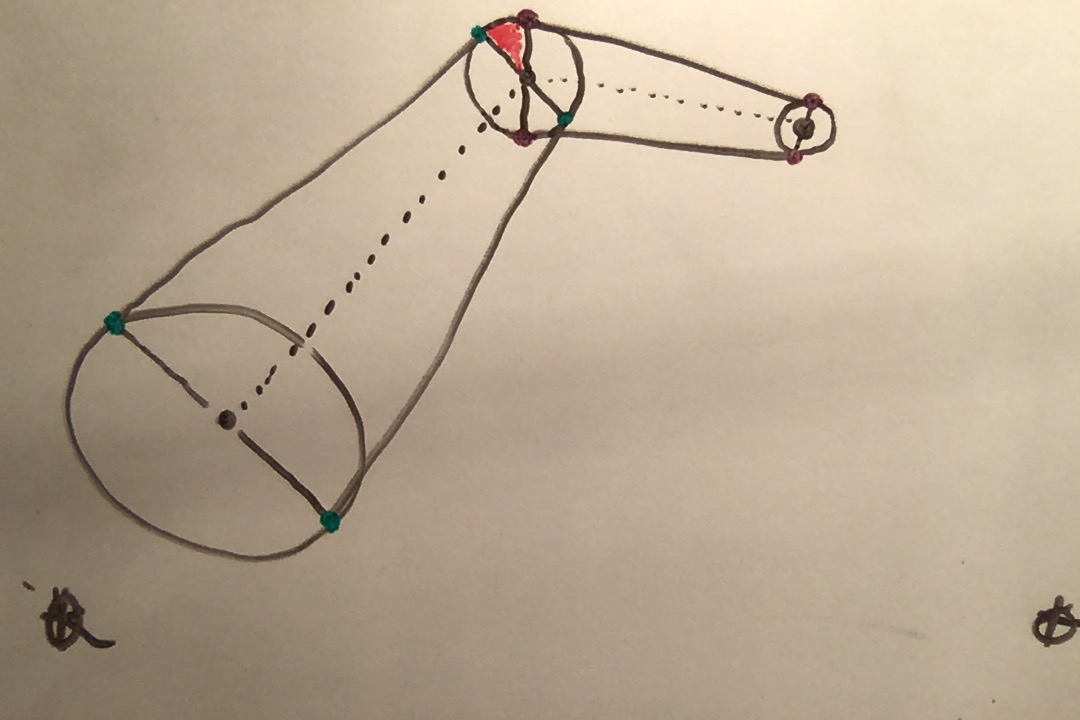

In [0]:
in_img = PIL.Image.open(in_file)
display(in_img)

How big are the pics? (MacBook Pro camera seems to be 1080x720) close to 100K in size

In [0]:
print(in_img.size)
!ls -lh "{in_file}"

(1080, 720)
-rw------- 1 root root 98K Apr 22 19:56 '/content/whiteboarder/gdrive/My Drive/Professional/Reconstrue/Whiteboard/2020/2020-04/plotting_knee_error_3.jpg'


# ImageMagick

The immortal cockroach know as ImageMagick.

TODO:
- [x] `!cli -call_to` imagemagick
- [ ] Python to ImageMagick
  - [wand](http://docs.wand-py.org/en/0.5.9/)
  - PythonMagick


## Fred's Whiteboard

Years ago, Fred Weinhaus cranked out the tool which originally inspired this notebook to happen. His ImageMagick script, [Whiteboard](http://www.fmwconcepts.com/imagemagick/whiteboard/index.php), is described as "Processes a picture of a whiteboard to clean up the background and correct the perspective." Old but nonetheless it was "last modified: December 16, 2018" so it is also long maintained.

### Install Fred's

In [0]:
# TODO: this commented out next line fails. A file is created but not usable.
# !wget -O freds_whiteboard http://www.fmwconcepts.com/imagemagick/downloadcounter.php?scriptname=whiteboard&dirname=whiteboard
#
# Take #2 was to manual test: download from fmwconcepts.com, cache in private gDrive, download same to Colab FS works.
# That worked so that's why it's cached in gDrive as freds_whiteboard_file_name.

# So install is just a cp
freds_dest = workspace_root_path + 'whiteboard' # whiteboard is file's orig name
!cp "{freds_whiteboard_file_name}" {freds_dest}

In [0]:
print(workspace_root_path)
!ls -lh {workspace_root_path} 

/content/whiteboarder/
total 36K
drwx------ 4 root root 4.0K Apr 27 20:09 gdrive
-rw------- 1 root root  29K Apr 27 20:11 whiteboard


In [0]:
!chmod u+x {freds_dest}

In [0]:
# Debug
#print(freds_whiteboard_file_name)
#print(freds_dest)

### Run Fred's

In [0]:
# !bash {freds_dest} -o 33 -e none -f 10 -S 150 -p 0.1 "{in_file}" out.jpg
!bash {freds_dest} -S 300 "{in_file}" out.jpg

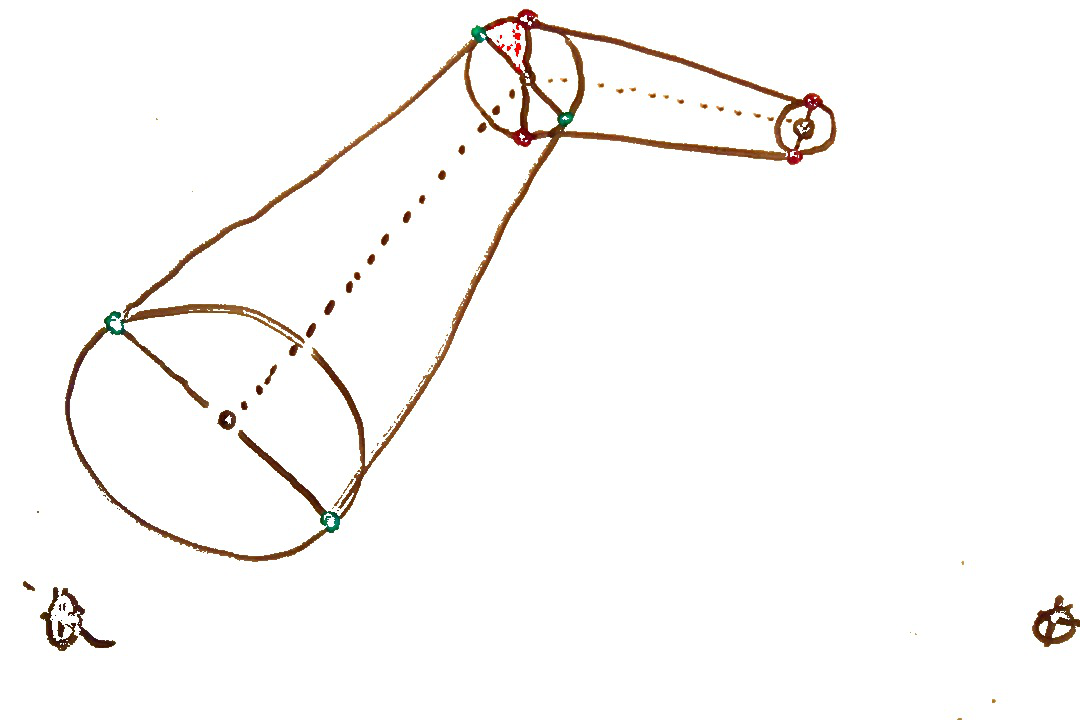

In [0]:
out_img = PIL.Image.open("out.jpg")
display(out_img)

In [0]:
# how to download files.download("out.jpg")

# Debug

In [0]:
# Debug

# import seaborn as sns, numpy as np
# sns.set(); np.random.seed(0)
# x = np.random.randn(100)
# ax = sns.distplot(x)

# OpenCV

OpenCV seems to be a widely adopted tool in the Python community and `cv2` is pre-installed on Colab so…

Here's someone who has already gone through the OpenCV on Colab tire kicking:
[Computer Vision - Instructional Exercise](https://colab.research.google.com/drive/1RWGmqoEQdeyh5TssoGtsXsFk8hbLGtWp). The next few cells repro those notes in the context of there here whiteboard images.

There seems to be a hassle on Colab WRT OpenCV. OpenCV used BGR color order, the reverse of the web's RGB order from HTML and CSS. But Colab doesn't like OpenCV's display utilities so we need to use something else, necessitating a translation from BRG => RGB.

In [0]:
# cv2_img = cv2.imread(in_file)
# # Here's the show-with-something-else bit: Matplotlib
# sns.set_style('dark')
# plt.imshow(cv2_img)
# plt.show()

In [0]:
# cv2 BGR => normal world RGB => MPL show()
def show_cv2_img(a_cv2_img):
  imgrgb = cv2.cvtColor(a_cv2_img, cv2.COLOR_BGR2RGB)
  sns.set_style('dark')
  plt.imshow(imgrgb)
  plt.show()

# show_cv2_img(cv2_img)

## Contrast & brightness


>Brightness and contrast adjustments
Two commonly used point processes are multiplication and addition with a constant:
```
g(x)=αf(x)+β
```
The parameters α>0 and β are often called the gain and bias parameters; sometimes these parameters are said to control contrast and brightness respectively.
You can think of f(x) as the source image pixels and g(x) as the output image pixels. Then, more conveniently we can write the expression as:
```
g(i,j)=α⋅f(i,j)+β
```
where i and j indicates that the pixel is located in the i-th row and j-th column.



In [a OpenCV doc](https://docs.opencv.org/3.4/d3/dc1/tutorial_basic_linear_transform.html) it has a "Changing the contrast and brightness of an image" tutorial.

# Histograms

Histograms are very useful for comprehending such things as [[*](https://towardsdatascience.com/histograms-in-image-processing-with-skimage-python-be5938962935)]:
>- Exposure
- Contrast
- Dynamic Range
- Saturation

## Grayscale

1D histograms. Simpler than color so let's start there.

**TODO:** grayscale is also an easy UI to generate just a binary mask: foreground and transparency mask for anything considered to be blank whiteboard space. Then just show the merged to the user.

### Dual histogram

Here "dual histogram" is a histogram with two lines:
- Normal binned distribution histogram
- Same info but cummulative

Such a UI is used as a diagnostic tool. The cummulative curve brings out the smoothness of a pixel intensity distribution; notice how a smooth red line is to been found behind the two good looking images:

<img src="https://scikit-image.org/docs/0.9.x/_images/plot_equalize_1.png" />

Following is derived from [Histograms in Image Processing with skimage-Python](https://towardsdatascience.com/histograms-in-image-processing-with-skimage-python-be5938962935):
```
NOTE: input file is gray.png

from skimage import io
import matplotlib.pyplot as plt
image = io.imread('~/Desktop/Lenna_gray.png')
_ = plt.hist(image.ravel(), bins = 256, cumulative = True)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count') 
plt.show()
```

### Matplotlib

In [0]:
from skimage import io
import matplotlib.pyplot as plt
image = io.imread(in_file)

# sns.set(style='dark')
# sns.distplot(image.ravel(), bins = 256, kde=False)
pass
#ax = plt.hist(image.ravel(), bins = 256, color='lightgray')
#plt.show()

In [0]:
# Debug

#import seaborn as sns, numpy as np
#sns.set(); 
#np.random.seed(0)
#x = np.random.randn(100)
#ax = sns.distplot(x)

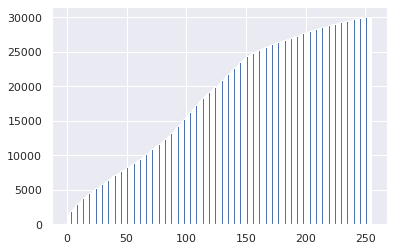

In [0]:
import requests 

# Color
#an_url = 'https://c8.alamy.com/comp/TYGH0J/martha-stewart-is-escorted-by-her-attorney-john-tigue-while-her-daughter-alexis-trails-behind-upon-arriving-at-manhattan-federal-court-on-march-5-2004-for-the-3rd-day-of-jury-deliberations-on-her-obstruction-of-justice-and-securities-fraud-trial-upiezio-petersen-TYGH0J.jpg'

# Grayscale
an_url = 'https://upload.wikimedia.org/wikipedia/commons/f/fa/Grayscale_8bits_palette_sample_image.png'

with open('resp.png', 'wb') as f:
  f.write(requests.get(an_url).content)
image = io.imread('resp.png')

plt.figure() #figsize=(3,3))
plt.hist(image.ravel(), bins = 256, cumulative = True)
plt.show()

TODO: `skimage.io` probably knows what its doing when taking a color image and plotting that via `revel(). But let's get a second opinion from OpenCV, using some code from [that CleverGirl article](https://www.pyimagesearch.com/2014/01/22/clever-girl-a-guide-to-utilizing-color-histograms-for-computer-vision-and-image-search-engines/):


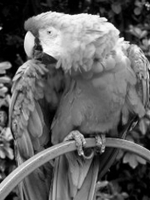

In [0]:
# convert the image to grayscale and create a histogram
#gray = cv2.cvtColor(image, cv2.COLOR) #, cv2.COLOR_BGR2GRAY)
gray = image

# TODO: temp patched on 2020-04-24
# See  https://github.com/reconstrue/brightfield/issues/206]
# original that Colab disabled: cv2.imshow("gray", gray)
# They suggested:
from google.colab.patches import cv2_imshow
cv2_imshow(gray)


(0.0, 256.0)

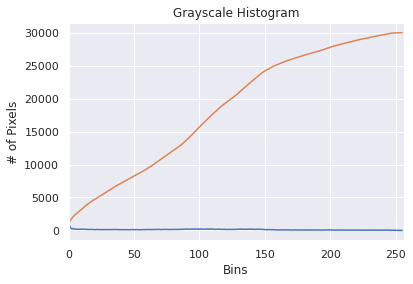

In [0]:
hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
hist_cumulative = hist.cumsum()


plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")

plt.plot(hist)
plt.plot(hist_cumulative)

plt.xlim([0, 256])

In [0]:
# How about zip it up and feed to Pandas? Not the most efficient?
import pandas as pd

eight_bit_range = np.arange(0, 256, 1)

# hist is an array of single element arrays of one float?
# Same for hist.cumsum() but simple array of floats? weird diff.
hist_dressed_up = np.asarray(hist.flatten(), dtype='int32')

collated = zip(eight_bit_range, hist_dressed_up, hist_cumulative)
pixels_hist_df = pd.DataFrame(collated, columns=['intensity','count', 'cumm'], dtype=np.int32)
pixels_hist_df.tail()


,intensity,count,cumm
251,251,15,29993
252,252,4,29997
253,253,0,29997
254,254,2,29999
255,255,1,30000


In [0]:
# https://seaborn.pydata.org/generated/seaborn.kdeplot.html
#seaborn.kdeplot(data, data2=None, shade=False, vertical=False, cumulative=False...
#But I do not want kde i want cum hist

print(np.asarray(hist.flatten(), dtype='int32'))

[853 601 264 272 213 205 159 164 154 168 179 201 165 163 155 140 143 152
 145 117 106 122 140 118 118 110 125 134 134 131 121 120 111 121 120 135
 127 130 103 111 105 116 106 109 111 117  92 114 127 110 104 112 123 101
  97  95 113 113 123 114 121 141 125 117 131 140 145 126 134 157 128 132
 147 153 140 153 115 146 137 129 146 139 146 136 154 148 153 175 163 183
 205 187 182 185 205 193 210 193 214 200 203 211 197 195 190 184 219 194
 200 202 185 171 159 173 194 189 178 149 157 173 137 147 149 146 139 153
 143 161 151 162 195 178 181 180 164 166 183 177 161 172 183 161 170 147
 164 192 159 158 157 138 125 108 114 104 120 103 113  93  82  88  75  85
  85  73  82  69  79  71  83  63  55  62  67  73  65  60  66  59  55  60
  68  62  57  53  40  50  53  63  74  51  59  71  47  52  56  72  80  60
  84  66  72  64  54  52  45  59  60  55  46  62  51  56  44  41  43  51
  51  50  46  50  52  52  39  53  38  49  37  41  32  52  38  39  46  42
  47  44  42  40  37  40  31  38  43  41  37  43  2

### Seaborn

The trick is `twinx()` which has the twins axes share the x-axis.
```
sns.set_style("dark")
#fig, ax1 = plt.subplots(

eight_bit_range = np.arange(0, 256, 1)
color = 'tab:gray'
ax1.set_xlabel('Intensity')
ax1.set_ylabel('Count', color=color)
ax1.plot(eight_bit_range, hist, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Cumulative', color=color)  
ax2.plot(eight_bit_range, hist_cumulative, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()
```

Separately it is describe in [Combo Charts with Seaborn and Python](https://towardsdatascience.com/combo-charts-with-seaborn-and-python-2bc911a08950) 

In [0]:
#create list of months
Month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 
         'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
#create list for made up average temperatures
Avg_Temp = [35, 45, 55, 65, 75, 85, 95, 100, 85, 65, 45, 35]
#create list for made up average percipitation %
Avg_Percipitation_Perc = [.90, .75, .55, .10, .35, .05, .05, .08, .20, .45, .65, .80]
#assign lists to a value
data = {'Month': Month, 'Avg_Temp': Avg_Temp, 'Avg_Percipitation_Perc': Avg_Percipitation_Perc}
#convert dictionary to a dataframe
df = pd.DataFrame(data)
#Print out all rows
df[:12]

,Month,Avg_Temp,Avg_Percipitation_Perc
0,Jan,35,0.90
1,Feb,45,0.75
2,Mar,55,0.55
3,Apr,65,0.10
4,May,75,0.35
5,June,85,0.05
6,July,95,0.05
7,Aug,100,0.08
8,Sep,85,0.20
9,Oct,65,0.45


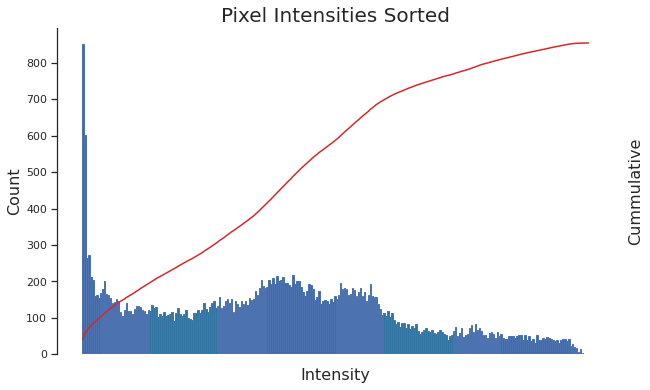

In [74]:
#Create combo chart
# pixels_hist_df = pd.DataFrame(collated, columns=['intensity','count', 'cumm'], dtype=np.int32)
fig, ax1 = plt.subplots(figsize=(10,6)) #, constrained_layout=True)
#sns.set_style('white') # this will trigger the bug
#plt.tight_layout(h_pad=0)
plt.subplots_adjust(wspace=0.01, hspace=0.01)

#for spine in ax1.spines:
#  spine.set_visible(False)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)


# Histogram as bars
color = 'tab:blue'
ax1.set_title('Pixel Intensities Sorted', fontsize=20)
ax1.set_xlabel('Intensity', fontsize=16)
ax1.set_ylabel('what???', fontsize=16)
ax1 = sns.barplot(x='intensity', y='count', data = pixels_hist_df, color=color) #palette='summer')
ax1.set(xlabel='Intensity', ylabel='Count'  )
ax1.tick_params(axis='y')

# specify we want to share the same x-axis
ax2 = ax1.twinx() 
sns.despine(ax=ax2, bottom=True)
#sns.despine(ax=ax2, right=True)

# Cummulative histogram as line
color = 'tab:red'
ax2.set_ylabel('Cummulative total pixels', fontsize=16)
sns.set_style({'patch.edgecolor': 'b'}) # This prevents style error to lots of verticle lines, seaborn overstyling the bars
ax2 = sns.lineplot(x='intensity', y='cumm', data=pixels_hist_df, sort=False, color=color) #, rc={})
#ax2.tick_params(axis='y', color=color)
ax2.tick_params(axis='y', right=False)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set(ylabel='Cummulative')
#fig.set_xlabel('Intensity', fontsize=16)
pass

TODO: there is also the issues of weighting the 3 channels to adjust to perceptual uniform.

[White Balance a photo from a known point](https://stackoverflow.com/a/54481969/4669056):
>The computation of lum will be better if using proper weights: 0.2126, 0.7152, 0.0722

### Plotly

This is not something that plotly is really recommending or not that i can find.

In [0]:

import plotly.graph_objects as go

import numpy as np

pixels = np.array(gray.ravel())
pixels_hist = np.histogram(pixels, bins=256, density=True)
pixels_hist_cummulative = np.cumsum(pixels_hist[0])

#fig = go.Figure(data=go.Scatter(x=pixels_hist[1], y=pixels_hist_cummulative))
fig = go.Figure(data=[go.Histogram(x=gray.ravel(), cumulative_enabled=False)])

fig.show()

In [0]:
# sns.set_style('white')

plt.figure() #figsize=(3,3))
plt.hist(image.ravel(), bins = 256, cumulative = True)
plt.show()

## Color break-out histograms

[What about sns.pairplot. Scatter is not histo but it's still color analysis. So, this should be moved to "Color stats"?]

Next is the per-channel histogram from [Histograms in Image Processing with skimage-Python](https://towardsdatascience.com/histograms-in-image-processing-with-skimage-python-be5938962935):


In [0]:
from skimage import io
import matplotlib.pyplot as plt
image = io.imread(in_file)

#_ = plt.hist(image.ravel(), bins = 256, color = 'lightgray', )
#_ = plt.hist(image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
#_ = plt.hist(image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

### Pixels projected to color space

Consider this image from [Clever Girl: A Guide to Utilizing Color Histograms for Computer Vision and Image Search Engines](https://www.pyimagesearch.com/2014/01/22/clever-girl-a-guide-to-utilizing-color-histograms-for-computer-vision-and-image-search-engines/)

<img src="https://pyimagesearch.com/wp-content/uploads/2014/01/grant-2d-histograms.png" />

Those are 3 sides of a cube. The cube volume is color space. One could think of it as a 3D histogram. Each pixel from the 2D image is actually a 3-part chunk of info (R,G,B). So, use those values to project to 3D. Then the 2D projections of that 3D volume will be those "3 sides of a cube."

Finally, there are multiple cubes: one for each color coding:
- RGB
- HSV
- Lab

OpenCV has easy functions for that: [cvtColor and friends](https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html#cvtcolor).


## User controls

## Sliders

[Tim Grey](http://asktimgrey.com/2016/07/11/exposure-versus-brightness/):
>the Exposure slider (such as that in Lightroom and Adobe Camera Raw) will use a scale based on exposure value (EV), which is measured in stops of light.
>
>A brightness adjustment also obviously adjusts the overall tonal values for an image, though with an adjustment typically measured as an overall percentage rather than exposure values.

## More sliders

2 gForm sliders on autorun. one alpha the other beta. Draw the histogram with a&b ramp curve over histo.

Analogous to what needs to be done to whiteboard images, [The Allen Institute calls the following "intensity windowing."](http://help.brain-map.org/display/mouseconnectivity/Projection#Projection-HighResolutionImageViewer) We're doing similar but for manual histogram equalization (whatever that kind of windowing is called).

<img src="http://help.brain-map.org/download/attachments/2588674/fig1.jpg?version=1&modificationDate=1330647199754&api=v2" />

And the sides of the window box are controlled by a range UI.

<img src="http://help.brain-map.org/download/attachments/2588674/fig2.jpg?version=1&modificationDate=1330647299789&api=v2" />

So in Colab that might be [an IntRangeSlider](https://ipython-books.github.io/33-mastering-widgets-in-the-jupyter-notebook/) ipywidget?




In [0]:
import ipywidgets as widgets
from IPython.display import display

In [0]:
range_slider = widgets.IntRangeSlider(
    value=[100, 220],
    min=0, max=255, step=1,
    description='Red',
    readout_format='d',
)
range_slider

TODO: 3 sliders for 3 color channels. That's the controls to the 3 color range filter.

<img src="http://help.brain-map.org/download/attachments/2588674/ImageControl.PNG?version=1&modificationDate=1393875335570&api=v2" width="50%" />

## Histogram equalization

As shown above, [scikit-image: Histogram Equalization](https://scikit-image.org/docs/0.9.x/auto_examples/plot_equalize.html) has code to make the following image. They are using that to compare the effects of various histogram equalization techniques. Let's, especially this "adaptive histogram equalization."

<img src="https://scikit-image.org/docs/0.9.x/_images/plot_equalize_1.png" width="50%"/>


## Saturation 

Saturation is quite simple Via [[stackoverflow](https://stackoverflow.com/a/49280629/4669056)]:

>```
def change_brightness(img, alpha, beta):
   return cv2.addWeighted(img, alpha, np.zeros(img.shape, img.dtype),0, beta)
```
Here alpha & beta are input parameters. Each pixel of the input image will change according to this formula.
```
  alpha(pixel_value) + beta.
```
Lower value of alpha like 2 or 3 is good


There is also more verbose options:
>The other answers suggest doing the saturation "by hand" using all kinds of numpy magic, but you can also use cv2.add() and let OpenCV handle that for you:
```python
import cv2
import numpy as np
image = cv2.read('image.png')
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
value = 42 #whatever value you want to add
cv2.add(hsv[:,:,2], value, hsv[:,:,2])
image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
cv2.imwrite('out.png', image)
```

Or less elegantly:
```python
img = cv2.imread('test.jpg') #load rgb image
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #convert it to hsv

h, s, v = cv2.split(hsv)
v += 255
final_hsv = cv2.merge((h, s, v))

img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
cv2.imwrite("image_processed.jpg", img)
```



# White balance

- [Tutorials: White Balance](https://www.cambridgeincolour.com/tutorials/white-balance.htm) from a generic photographer perspective, good intro
- [Color Balance in Digital Imaging](https://www.microscopyu.com/digital-imaging/color-balance-in-digital-imaging) on microscopyu.com
- Some hand coding:
  - [Correcting image white balance with Python PIL and Numpy](https://codeandlife.com/2019/08/17/correcting-image-white-balance-with-python-pil-and-numpy/)
  - [Automatic White Balancing with Grayworld assumption
](https://stackoverflow.com/questions/46390779/automatic-white-balancing-with-grayworld-assumption)


## Simple White Balance

I think this might have started as this Matlab code [simplestColorBalance.m](https://web.stanford.edu/~sujason/ColorBalancing/simplestcb.html#nogo), as [discussed on stackoverflow](https://stackoverflow.com/a/49481583/4669056).

- https://stackoverflow.com/a/49481583/4669056
  - https://gist.github.com/DavidYKay/9dad6c4ab0d8d7dbf3dc

### Xphoto
https://stackoverflow.com/a/49836244/4669056:

>The answer can be found in [the xphoto documentation](https://docs.opencv.org/3.4.1/df/db9/namespacecv_1_1xphoto.html)
.  
>The appropriate methods to create the WB algorithms are createSimpleWB(), createLearningBasedWB() and createGrayworldWB().  
> &nbsp;   
>Example:
```python
wb = cv2.xphoto.createGrayworldWB()
wb.setSaturationThreshold(0.99)
image = wb.balanceWhite(image)
```


```
simple_wb = cv2.xphoto.createSimpleWB()
simple_img = simple_wb.balanceWhite(cv2_img)

gray_wb = cv2.xphoto.createGrayworldWB()
gray_wb.setSaturationThreshold(0.99)
gray_img = gray_wb.balanceWhite(cv2_img)

learning_wb = cv2.xphoto.createLearningBasedWB()
learning_img = learning_wb.balanceWhite(cv2_img)

show_cv2_img(cv2_img)
show_cv2_img(simple_img)
show_cv2_img(gray_img)
show_cv2_img(learning_img)

```

## Learning white balance

https://docs.opencv.org/master/dc/dcb/tutorial_xphoto_training_white_balance.html

>Many traditional white balance algorithms are statistics-based, i.e. they rely on the fact that certain assumptions should hold in properly white-balanced images like the well-known grey-world assumption. However, better results can often be achieved by leveraging large datasets of images with ground-truth illuminants in a learning-based framework. This tutorial demonstrates how to train a learning-based white balance algorithm and evaluate the quality of the results.

# Microscopy techniques

Whiteboard images are kinda like brightfield microscopy images.



## CLAHE and Rolling ball

[brightfield issue](https://github.com/reconstrue/brightfield/issues/192):
- [23 - Histogram based image segmentation in Python](https://www.youtube.com/watch?v=kIVk0IhDMwY)
- [27 - CLAHE and Thresholding using opencv in Python](https://www.youtube.com/watch?v=XfDkg3z3BCg)
- [117 - Shading correction using rolling ball background subtraction](https://www.youtube.com/watch?v=hy5PlXX-CU0)
- [113 - Histogram equalization and CLAHE](https://www.youtube.com/watch?v=jWShMEhMZI4)


### Denoising

- https://github.com/reconstrue/brightfield/issues/203
- https://github.com/reconstrue/brightfield/issues/196

## Thresholding

Maybe first threshold to ink (any color) vs whiteboard. Then sort black, red, green.

[How to OTSU threshold in cv2](https://github.com/bnsreenu/python_for_microscopists/blob/master/027-image_processing_in_openCV_intro2-Thresholding.py):
```python
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("images/Alloy.jpg", 0)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))  #Define tile size and clip limit. 
clahe_img = clahe.apply(img)

plt.hist(clahe_img.flat, bins =100, range=(0,255))

# binary thresholding
ret1,th1 = cv2.threshold(clahe_img,185,200,cv2.THRESH_BINARY)

# Otsu's thresholding, automatically finds the threshold point. 
#Compare wth above value provided by us (185)
ret2,th2 = cv2.threshold(clahe_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
```


#### Color thresholding

[Color Thresholding in OpenCV](https://medium.com/@ckyrkou/color-thresholding-in-opencv-91049607b06d) say define an upper and a lower bound color.

```python
lower_color_bounds = cv.Scalar(100, 0, 0)
upper_color_bounds = cv.Scalar(225,80,80)

gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
mask = cv2.inRange(frame,lower_color_bounds,upper_color_bounds )
mask_rgb = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)
frame = frame & mask_rgb
cv2.imshow(‘Video’,frame)
```

# Dimensionality reduction

Neighborhooders (tSNE, UMAP, etc.) can easily project 3D color space to 2D, and then cluster pixels to classify to color.

KNN would have 4 cluster a priori.

# Black, white, red, green

My blackboard images are drawn with three dry erase pens:
- Black
- Red
- Green

The whiteboard is white, or transparent.


## K-Means color classification

If the goal is an image with only four colors, then this might well be a situation within which to apply [K-Means](https://www.youtube.com/watch?v=EItlUEPCIzM) classification.

So, in this case the answer classifies each pixel to one of four colors i.e. the number of classes is known a priori. Sounds like K-Means should be dusted off: [51 - Image Segmentation using K-means](https://www.youtube.com/watch?v=6CqRnx6Ic48).


## Color classifier pipeline

Maybe:
1. anything above a max is whited (and that's transparent). 
2. Anything below a min is black? 
3. then red and green should be seperable in the middle by histogram? OTSU? K-Means? SVM?




# Appendices

## How to upload files
```python
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
```